In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [ ]:
if scenario.endswith('_equilibrium'):
    sm = stepmodel.read_json(model_path + scenario[:-12] + '/' + 'de_pt_los')
else:
    sm = stepmodel.read_json(model_path + scenario + '/' + 'de_pt_los')

In [5]:
car = stepmodel.read_json(model_path + scenario + '/' + 'de_road_los')

In [6]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

6.3727079961634585

In [7]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.232764057404997

In [8]:
# Define route types for the choice tree
route_types = ['rail',#'rail_long', 'rail_short',
               'bus',#'coach', 'bus',
               'air','car', 'walk']

In [9]:
sm.pt_los['route_type'].unique()

array(['bus', 'rail', 'air', 'walk'], dtype=object)

In [10]:
# Aggregate route types rail and road PT
type_dict = {'rail_long': 'rail', 'rail_short': 'rail', 'rail': 'rail',
             'coach': 'bus', 'bus': 'bus',
             'air': 'air', 'car': 'car', 'walk': 'walk'}
assert set(route_types).issubset(set(type_dict.keys()))
if 'rail_short' in sm.pt_los['route_type']:
    sm.pt_los['route_type_network'] = sm.pt_los['route_type'].copy()
sm.pt_los['route_type'] = sm.pt_los['route_type'].map(type_dict)

In [11]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"('business_no_car', 'probability')","('business_car', 'probability')","('education_no_car', 'probability')","('education_car', 'probability')","('buy/execute_no_car', 'probability')","('buy/execute_car', 'probability')","('leisure_no_car', 'probability')","('leisure_car', 'probability')","('accompany_no_car', 'probability')","('accompany_car', 'probability')"
index,,,,,,,,,,,,,,,,,,,,,
5681798,DE80L_4,DEB3J_0,"[coach, bus]","[bus_892128, bus_1587219, bus_1587220, bus_158...",6,937835,2160,721,31680,12304,...,0.250129,0.017553,0.98777,0.521861,0.862107,0.03846,0.836435,0.035497,0.999929,0.002175


In [12]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

15257717

In [13]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [14]:
# Drop columns from previous logit model runs
sm.los.drop([col for col in sm.los.columns if col.startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [15]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

15257717

## Prepare the logit model

Load parameters and generate LoS columns

In [16]:
# Transport demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

In [17]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results.xls')
params_est = {}
for s in segments: # First two sheets are all purposes
    df = excel.parse(s.replace('/', '-'))
    params_est[s] = df.set_index(df.columns[0])

In [18]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['root']*len(route_types) + [np.nan] #['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['root'], #['pt', 'root'],
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
route_type,,,,,,,,,,,,
rail,root,root,root,root,root,root,root,root,root,root,root,root
bus,root,root,root,root,root,root,root,root,root,root,root,root
air,root,root,root,root,root,root,root,root,root,root,root,root
car,root,root,root,root,root,root,root,root,root,root,root,root
walk,root,root,root,root,root,root,root,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for i in range(len(segments))]
# For the nested structure
#sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
#                             for i in range(len(segments))]
sm.logit_scales

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail,1,1,1,1,1,1,1,1,1,1,1,1
bus,1,1,1,1,1,1,1,1,1,1,1,1
air,1,1,1,1,1,1,1,1,1,1,1,1
car,1,1,1,1,1,1,1,1,1,1,1,1
walk,1,1,1,1,1,1,1,1,1,1,1,1
root,1,1,1,1,1,1,1,1,1,1,1,1


In [20]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail', 'asc_rail'),
#               ('rail_short', 'asc_rail_s'),
#               ('rail_long', 'asc_rail_l'),
#               ('coach', 'asc_coach'),
               ('bus', 'asc_road'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[s].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for s in segments]
sm.mode_utility

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail,2.655723,-2.070340,1.579961,-3.039669,3.386732,-0.367500,2.487876,-3.241734,2.652331,-2.717116,4.548259,-4.413824
bus,2.193561,-3.003936,0.475713,-3.653070,3.656378,0.266099,2.350080,-3.876845,2.112531,-3.117065,2.604413,-4.613033
air,-3.694299,-4.875724,-1.935803,-2.221547,-5.432744,-4.479551,-5.149762,-2.175679,-4.786481,-0.871614,1.722263,-6.493368
car,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-1.154985,-5.974286,-0.119871,-5.592291,-1.610366,-2.746705,0.311806,-4.608588,0.021619,-3.626567,-8.874935,-5.432136
root,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Performance attributes for mode choice
perf_attrs = [s+'_time' for s in segments] + [s+'_price' for s in segments]

In [23]:
# Beta parameters from calibration data
# IMPORTANT: mind the unit conversion
sm.utility_values = pd.DataFrame({s: [0 for _ in perf_attrs] for s in segments},
                                 index=[str(a) for a in perf_attrs])
#sm.utility_values.loc['waiting_time'] = [params_est[seg].loc['b_wt', 'Value'] for seg in segments]
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for s in segments:
    sm.utility_values.loc[s+'_time', s] = params_est[s].loc['b_t', 'Value']
    try:
        sm.utility_values.loc[s+'_price', s] = params_est[s].loc['b_c', 'Value']
    except KeyError: # Business has no b_c
        sm.utility_values.loc[s+'_price', s] = 0
sm.utility_values

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
commuting_no_car_time,-0.013271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
commuting_car_time,0.000000,-0.022637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_no_car_time,0.000000,0.000000,-0.020984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_car_time,0.000000,0.000000,0.000000,-0.012319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_no_car_time,0.000000,0.000000,0.000000,0.000000,-0.084707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,-0.072867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_no_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.075958,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.023919,0.000000,0.000000,0.000000,0.000000
leisure_no_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.021623,0.000000,0.000000,0.000000
leisure_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015579,0.000000,0.000000


In [24]:
# Generate damped cost (see cal20)
c = params['estimation'].to_dict()
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    return (beta*theta[0]*np.power(np.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*np.power(np.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*np.power(np.log(x),Q-3+1) + alpha[2]) * (x>=c2)

In [25]:
# Apply the spline function
for s in tqdm(segments):
#    for a in perf_attrs:
#        sm.los[a] = [spline(gc, beta) for gc in sm.los[(s, 'gc')]]
    c1 = c['c1_time_'+s]
    c2 = c['c2_time_'+s]
    beta = sm.utility_values.loc[s+'_time', s]
    sm.los[s+'_time'] = [spline(t*60, beta, c1*60, c2*60) for t in sm.los['time']]

In [26]:
# Make beta_t one because it is now included in the LoS attribute 't'
for s in segments:
    sm.utility_values.loc[s+'_time', s] = 1

## Mode Choice

In [27]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:19<00:00,  6.64s/it]


In [28]:
# Run the logit model to calculate probabilities
sm.step_logit()

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [53:47<00:00, 322.73s/it]


In [29]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(59330040, 9)
(59330040, 9)


In [30]:
sm.probabilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
5556740,DEF09_1,DE27C_1,education_car,1,0.0,9.785843e-01,0.0,0.000000,0.021416
3517597,DE923_2,DED51_0,accompany_no_car,1,0.0,4.349379e-09,0.0,0.256654,0.743346
3598797,DE929_4,DEF06_1,education_no_car,1,0.0,2.917560e-05,0.0,0.430090,0.569881


In [31]:
sm.utilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
52821,DE114_2,DEG0G_3,education_no_car,-3.290972,-inf,-19.505036,-inf,-3.445515,-5.234533
2900484,DE719_5,DEA55_0,accompany_car,-2.976855,-inf,-2.988523,-inf,-8.953686,-7.680419
5378052,DEE09_7,DE939_2,accompany_car,-2.890711,-inf,-2.903377,-inf,-8.853103,-7.494592


In [32]:
sm.los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
13059544,DE911_0,DE404_0,"(car,)","[rl_18018, rl_18994, rl_18997, rl_18763, rl_19...",NaN,214664,300,NaT,7075,NaT,...,0.098546,0.90494,0.000019,0.341668,0.003901,0.938901,0.006839,0.891141,0.000001,0.984405


In [33]:
# Validate that probabilities sum up to one
od = sm.los.groupby(['origin', 'destination']).sum()[
    [(seg, 'probability') for seg in sm.segments]].mean(axis=1)
print(od.mean())
print(od.max())
print(od.min())

1.0
1.0000000000000002
0.9999999999999999


## Save model

In [34]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_json(model_path + scenario + '/' + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 15/15 [10:25<00:00, 41.67s/it]


In [35]:
# Save LoS table
if 'route_type_network' in sm.los.columns:
    sm.los['route_type'] = sm.los['route_type_network']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car'].reset_index()
sm.to_json(model_path + scenario + '/' + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car'].reset_index()
sm.to_json(model_path + scenario + '/' + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 16/16 [05:41<00:00, 21.32s/it]


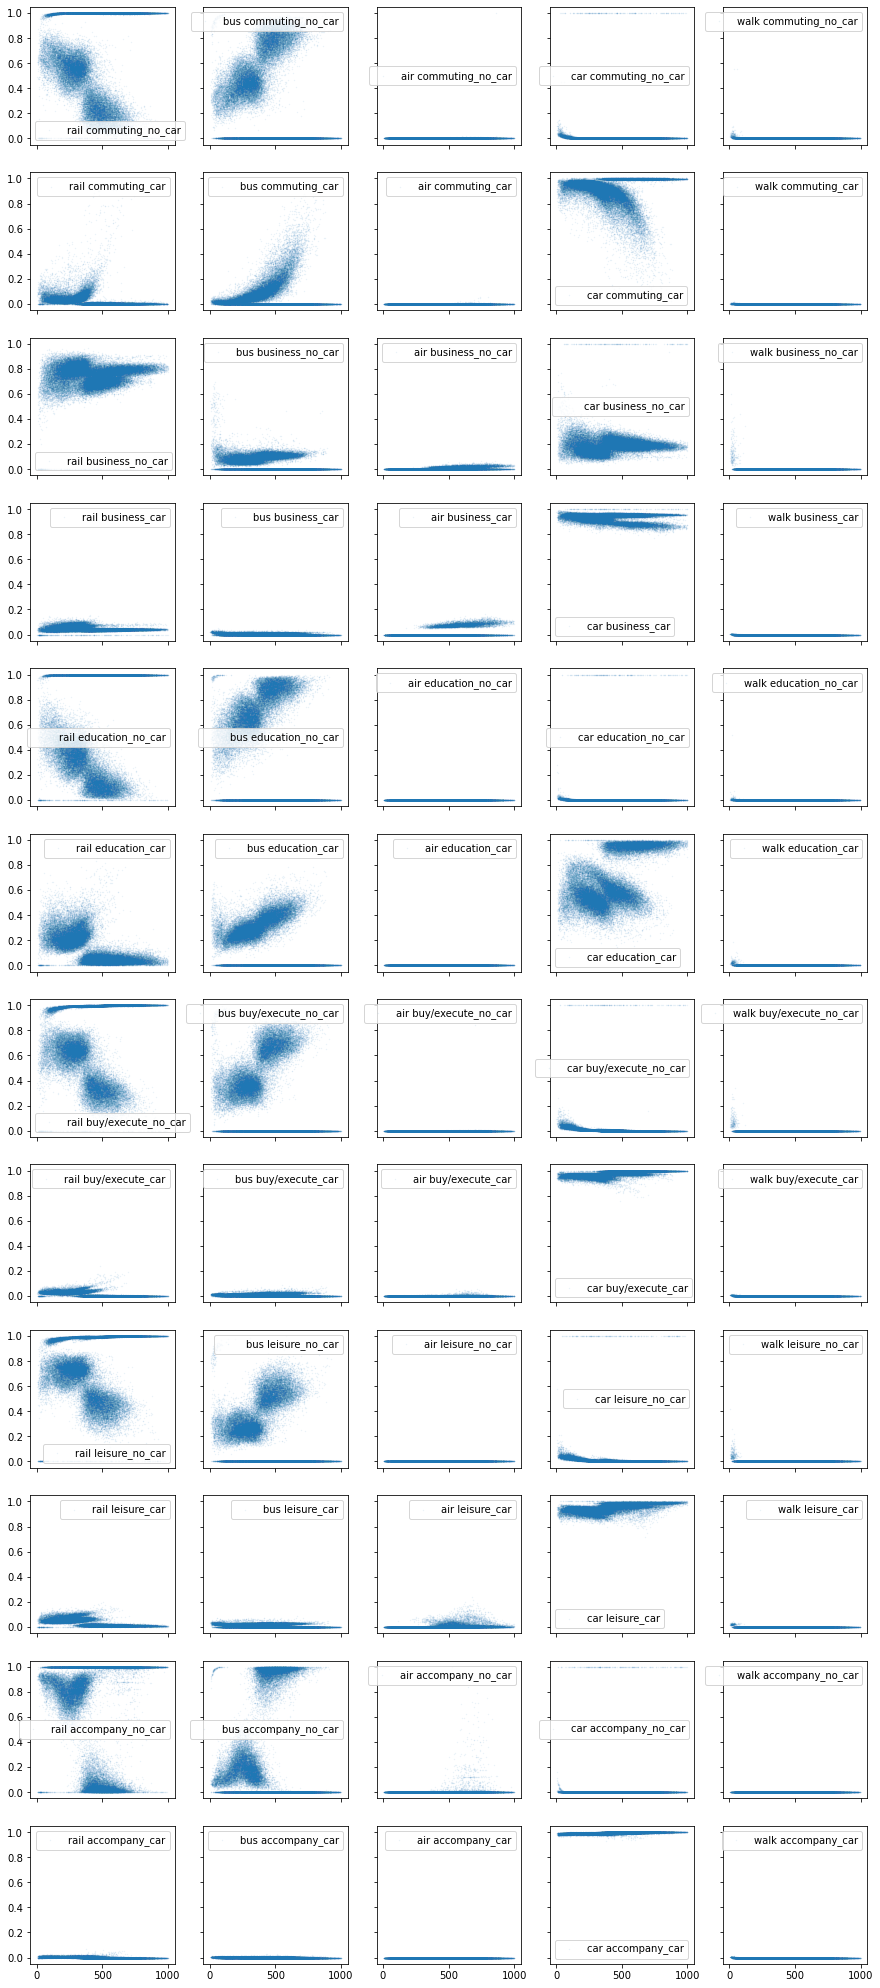

In [36]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.sample(int(len(sm.probabilities)**0.5)).merge(
        car.car_los[['origin', 'destination', 'length']],
        on=['origin', 'destination'],
        how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(15,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].legend()

### Save composite generalised cost / logsum
For sequential destination choice modelling

In [37]:
# define the logsum function with numpy
def logsum(v_list):
    # Given a list of pre-calculated negative utilities
    return np.log(np.sum([np.exp(-1 * v) for v in v_list]))

In [38]:
# Make price utility negative by multiplying with betas (time already is)
for s in segments:
    price_col = s + '_price'
    sm.los[price_col] *= sm.utility_values.loc[price_col, s]

In [39]:
# Calculate composite cost for price and time
comp_cost = sm.los.groupby(['origin', 'destination']).agg(
    {col: logsum for col in perf_attrs})

KeyboardInterrupt: 

In [ ]:
# Sum up generalised cost
for s in segments:
    attrs = [s+'_time', s+'_price']
    comp_cost[s] = comp_cost[attrs].sum(axis=1)
    comp_cost.drop(attrs, axis=1, inplace=True)

In [ ]:
# Save
comp_cost.to_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')

In [ ]:
# Calculate the logsum
comp_u = sm.los.groupby(['origin', 'destination']).agg(
    {(s, 'utility'): logsum for s in segments})

In [ ]:
# Save it
#comp_u.columns = [c.split("'")[1] for c in comp_u.columns]
comp_u.to_csv(output_path + scenario + '/mode_choice_od_composite_utility.csv')